In [1]:
using DrWatson
@quickactivate "Doran_etal_2022"

using CSV, DataFrames, Muon
using SPI
using StatsBase
using StatsPlots
theme(:default, grid=false, tickdir=:out, label="")
# plotlyjs()

include(srcdir("helpers.jl"))

using NewickTree
using NewickTreeTools
include(srcdir("MIcurve_functions.jl"))

collectMI_across_treedepth (generic function with 1 method)

In [2]:
csbdir = datadir("exp_pro", "BB669")
rdir = projectdir("_research", "CSB669_MIcurves") |> mkpath
pdir = plotsdir("CSB669_MIcurves") |> mkpath

"/Users/ben/projects/Doran_etal_2022/plots/CSB669_MIcurves"

In [3]:
csbspitree = readnw(open(readline, joinpath(csbdir, "BB669_inferred_spitree_nj.nw")));
csbobs = CSV.read(joinpath(csbdir, "BB669_rowmeta.csv"), DataFrame);

In [4]:
biobank = readh5mu(joinpath(csbdir, "BB669.h5mu"))

┌ Warning: Cannot join columns with the same name because var_names are intersecting.
└ @ Muon /Users/ben/.julia/packages/Muon/eLqpV/src/mudata.jl:351


MuData object 669 ✕ 21485
└ metabolites_foldchange
  AnnData object 669 ✕ 50
└ metabolites_millimolar
  AnnData object 669 ✕ 10
└ UPorder_oggs
  AnnData object 669 ✕ 10177
└ oggs
  AnnData object 669 ✕ 11248

In [5]:
gtdb_cols = [:phylum_gtdb, :class_gtdb, :order_gtdb, :family_gtdb, :genus_gtdb, :species_gtdb, :donor]
ncbi_cols = [:phylum_ncbi, :class_ncbi, :order_ncbi, :family_ncbi, :genus_ncbi, :species_ncbi, :donor]
NCUTS = 100
NBOOT = 50

50

## NCBI taxonomy

In [6]:
rowmeta = csbobs[:, ncbi_cols]
havelabels = vec(mapslices(r->all(r .!= "<unclassified>"), Matrix(rowmeta), dims=2));
IDS = csbobs.ID;

In [8]:
spi_tree_50pct = as_polytomy(n->NewickTree.support(n)<0.5, csbspitree)


((((((MSK.22.4:0.0009970886,MSK.22.2:0.0004595173):0.0006471248,MSK.22.68:0.0):6.183301e-5,(MSK.22.57:0.0,MSK.22.64:0.0003689898):0.0001865055):8.78389e-5,(((((((((((MSK.22.80:0.003300148,MSK.22.73:0.005227851):0.006349715,MSK.22.108:0.0):0.0004065526,MSK.22.65:0.0):0.0002139751,MSK.22.109:0.0):0.0001796595,((((((MSK.8.32:0.002426758,MSK.7.17:0.003586496):0.007869967,MSK.7.22:0.0003214604):0.2192506,MSK.11.28:0.2397704):0.2347979,(((((((((((((((MSK.2.98:0.01772556,MSK.2.94:0.0):0.005682687,MSK.2.90:0.001706679):0.007909704,MSK.2.80:0.00279638):0.002268329,MSK.2.73:0.002162663):0.003139493,MSK.2.63:0.002096595):0.1493062,(MSK.2.78:0.0,MSK.2.26:0.3768796):0.2001333):0.3619538,MSK.2.59:0.4410711):0.5058078,DFI.1.207:2.45072):0.3548643,(MSK.1.17:0.001183832,MSK.1.13:0.01271928):2.436483):0.8198028,(((MSK.1.7:0.00103855,MSK.1.9:0.0):0.404271,MSK.7.21:0.636816):0.2734524,DFI.5.64:1.697332):1.996555):0.5557078,(((((((DFI.1.218:0.002438539,DFI.1.221:0.0):0.001073523,(((((DFI.1.214:0.001867755,

In [9]:
clusterids, clustersmps = clusters_per_cutlevel(NewickTreeTools.network_distance, spi_tree_50pct, NCUTS);

669-element Vector{String}:
 "MSK.22.4"
 "MSK.22.2"
 "MSK.22.68"
 "MSK.22.57"
 "MSK.22.64"
 "MSK.22.80"
 "MSK.22.73"
 "MSK.22.108"
 "MSK.22.65"
 "MSK.22.109"
 ⋮
 "MSK.22.102"
 "MSK.22.111"
 "MSK.22.45"
 "MSK.22.113"
 "MSK.22.101"
 "MSK.22.11"
 "MSK.22.34"
 "MSK.22.100"
 "MSK.22.106"

In [17]:
clustersmps[1] == getleafnames(spi_tree_50pct)

true

In [7]:
spi_tree_50pct = as_polytomy(n->NewickTree.support(n)<0.5, csbspitree)

@info "calculate tree cuts for SPI tree..."
@time clusterids, clustersmps = clusters_per_cutlevel(NewickTreeTools.network_distance, spi_tree_50pct, NCUTS);

@info "calculate test MI for SPI tree..."
@time spiMI_df = pairedMIagainstmetacolumn(rowmeta, IDS, clusterids, clustersmps; mask=havelabels);

@info "calculate boot MI for SPI tree..."
@time spiMI_bootstrapped = map(1:NBOOT) do i
    df = pairedMIagainstmetacolumn(rowmeta, IDS, clusterids, clustersmps; bootstrap=true, mask=havelabels)
    df.MI
end |> stack


@info "reformat boot replicates..."
@time begin
spiMI_df[!, :MI_boot_mean] = vec(mean(spiMI_bootstrapped, dims=2))
spiMI_df[!, :MI_boot_std] = vec(std(spiMI_bootstrapped, dims=2));
spiMI__bootstraps_df = DataFrame(spiMI_bootstrapped, [Symbol("MI_boot_$i") for i in 1:size(spiMI_bootstrapped, 2)]);
SPI_pltdf = hcat(spiMI_df, spiMI__bootstraps_df);
boot_SPI_pltdf = SPI_pltdf[!, ["taxaID", ["MI_boot_$i" for i in 1:NBOOT]...]] |>
    df-> groupby(df, :taxaID) |>
    gdf-> DataFrames.combine(gdf,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ms = vec(mean(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_mean,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ss = vec(std(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_std,
    );
end

┌ Info: calculate tree cuts for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/18_CSB669_MIcurves.ipynb:3


  2.188854 seconds (7.06 M allocations: 464.511 MiB, 7.18% gc time, 79.41% compilation time)


┌ Info: calculate test MI for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/18_CSB669_MIcurves.ipynb:6


  9.365431 seconds (9.00 M allocations: 2.876 GiB, 7.46% gc time, 57.18% compilation time: 1% of which was recompilation)


┌ Info: calculate boot MI for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/18_CSB669_MIcurves.ipynb:9


257.199858 seconds (7.69 M allocations: 171.127 GiB, 5.84% gc time, 0.35% compilation time: <1% of which was recompilation)


┌ Info: reformat boot replicates...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/18_CSB669_MIcurves.ipynb:16


  3.416730 seconds (6.58 M allocations: 413.086 MiB, 6.15% gc time, 99.62% compilation time: 9% of which was recompilation)


Row,taxaID,cumulative_boot_mean,cumulative_boot_std
,String,Float64,Float64
1,phylum_ncbi,0.0,0.0
2,phylum_ncbi,0.0011402,3.54403e-5
3,phylum_ncbi,0.00228671,4.14527e-5
4,phylum_ncbi,0.00361606,5.34173e-5
5,phylum_ncbi,0.00494798,6.68452e-5
6,phylum_ncbi,0.00730606,8.49376e-5
7,phylum_ncbi,0.00965739,9.2322e-5
8,phylum_ncbi,0.0120206,9.97887e-5
9,phylum_ncbi,0.0145803,0.000113235


In [60]:
CSV.write(joinpath(rdir, "spi_MI_ncbi.csv"), spiMI_df)
CSV.write(joinpath(rdir, "spi_MI_ncbi_bootstraps.csv"), SPI_pltdf)
CSV.write(joinpath(rdir, "spi_MI_ncbi_bootstraps_aggregated.csv"), boot_SPI_pltdf)

"/Users/ben/projects/Doran_etal_2022/_research/CSB669_MIcurves/spi_MI_ncbi_bootstraps_aggregated.csv"

In [61]:
taxonomylevels = permutedims(string.(ncbi_cols))
taxarankcolors = [:red :pink :orange :lightblue :green :aqua :lightgreen];

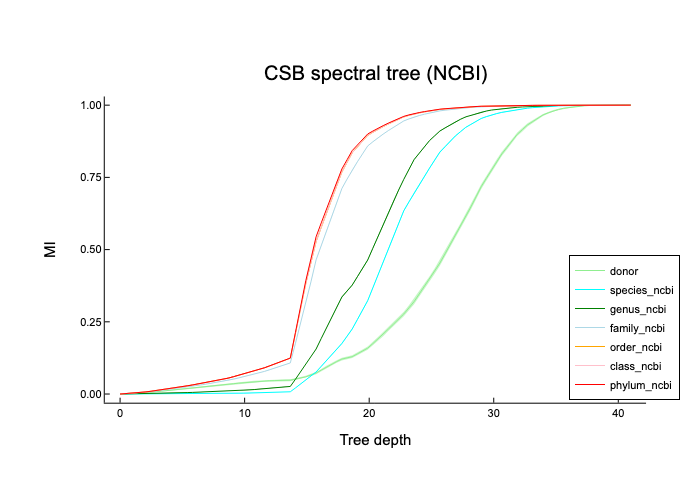

In [62]:
minmax = extrema(mapinternalnodes(network_distance, spi_tree_50pct, spi_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS)

plot(title="CSB spectral tree (NCBI)", ylabel="MI", xlabel="Tree depth",
    legend=:outerright,
    size=(600,250),  
)
for (tlab, tcol) in reverse(collect(zip(taxonomylevels, taxarankcolors)))
    df = filter(:taxaID=> ==(tlab), boot_SPI_pltdf)
    @df df plot!(cuts, :cumulative_boot_mean, ribbon=2 .* :cumulative_boot_std, label=tlab, c=tcol, lw=1)
end
plot!()

In [63]:
savefig(joinpath(pdir, "CSB_NCBI_MIcurves_boot50_cuts100.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/CSB669_MIcurves/CSB_NCBI_MIcurves_boot50_cuts100.pdf"

## GTDB taxonomy

In [64]:
rowmeta = csbobs[:, gtdb_cols]
havelabels = vec(mapslices(r->all(r .!= "<unclassified>"), Matrix(rowmeta), dims=2));
IDS = csbobs.ID;

In [65]:
spi_tree_50pct = as_polytomy(n->NewickTree.support(n)<0.5, csbspitree)

@info "calculate tree cuts for SPI tree..."
@time clusterids, clustersmps = clusters_per_cutlevel(NewickTreeTools.network_distance, spi_tree_50pct, NCUTS);

@info "calculate test MI for SPI tree..."
@time spiMI_df = pairedMIagainstmetacolumn(rowmeta, IDS, clusterids, clustersmps; mask=havelabels);

@info "calculate boot MI for SPI tree..."
@time spiMI_bootstrapped = map(1:NBOOT) do i
    df = pairedMIagainstmetacolumn(rowmeta, IDS, clusterids, clustersmps; bootstrap=true, mask=havelabels)
    df.MI
end |> stack


@info "reformat boot replicates..."
@time begin
spiMI_df[!, :MI_boot_mean] = vec(mean(spiMI_bootstrapped, dims=2))
spiMI_df[!, :MI_boot_std] = vec(std(spiMI_bootstrapped, dims=2));
spiMI__bootstraps_df = DataFrame(spiMI_bootstrapped, [Symbol("MI_boot_$i") for i in 1:size(spiMI_bootstrapped, 2)]);
SPI_pltdf = hcat(spiMI_df, spiMI__bootstraps_df);
boot_SPI_pltdf = SPI_pltdf[!, ["taxaID", ["MI_boot_$i" for i in 1:NBOOT]...]] |>
    df-> groupby(df, :taxaID) |>
    gdf-> DataFrames.combine(gdf,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ms = vec(mean(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_mean,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ss = vec(std(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_std,
    );
end

┌ Info: calculate tree cuts for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/18_CSB669_MIcurves.ipynb:3


  0.571823 seconds (4.99 M allocations: 330.207 MiB, 22.75% gc time)


┌ Info: calculate test MI for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/18_CSB669_MIcurves.ipynb:6


  4.256973 seconds (118.56 k allocations: 2.480 GiB, 5.96% gc time)


┌ Info: calculate boot MI for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/18_CSB669_MIcurves.ipynb:9


295.123470 seconds (6.44 M allocations: 182.137 GiB, 12.32% gc time, 0.04% compilation time)


┌ Info: reformat boot replicates...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/18_CSB669_MIcurves.ipynb:16


  0.152089 seconds (226.02 k allocations: 15.131 MiB, 96.17% compilation time)


Row,taxaID,cumulative_boot_mean,cumulative_boot_std
,String,Float64,Float64
1,phylum_gtdb,0.0,0.0
2,phylum_gtdb,0.0011604,2.77737e-5
3,phylum_gtdb,0.00231627,3.38452e-5
4,phylum_gtdb,0.00367006,4.12945e-5
5,phylum_gtdb,0.0050206,4.56972e-5
6,phylum_gtdb,0.00741258,5.99453e-5
7,phylum_gtdb,0.00981488,7.20119e-5
8,phylum_gtdb,0.0122075,8.53663e-5
9,phylum_gtdb,0.0148004,8.59134e-5


In [66]:
CSV.write(joinpath(rdir, "spi_MI_gtdb.csv"), spiMI_df)
CSV.write(joinpath(rdir, "spi_MI_gtdb_bootstraps.csv"), SPI_pltdf)
CSV.write(joinpath(rdir, "spi_MI_gtdb_bootstraps_aggregated.csv"), boot_SPI_pltdf)

"/Users/ben/projects/Doran_etal_2022/_research/CSB669_MIcurves/spi_MI_gtdb_bootstraps_aggregated.csv"

In [67]:
taxonomylevels = permutedims(string.(gtdb_cols))
taxarankcolors = [:red :pink :orange :lightblue :green :aqua :lightgreen];

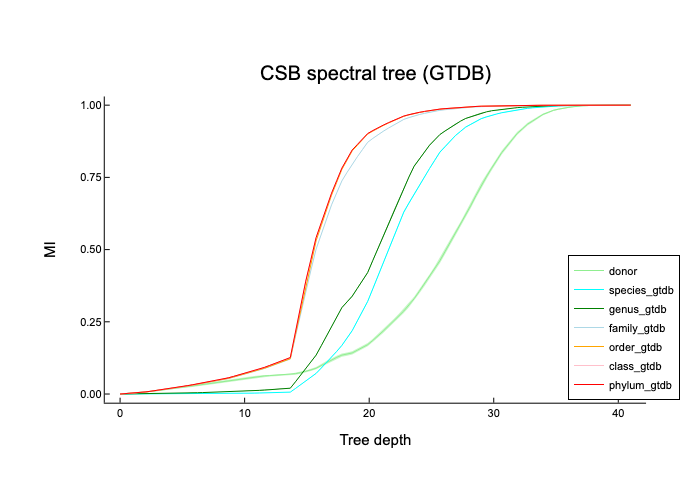

In [68]:
minmax = extrema(mapinternalnodes(network_distance, spi_tree_50pct, spi_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS)

plot(title="CSB spectral tree (GTDB)", ylabel="MI", xlabel="Tree depth",
    legend=:outerright,
    size=(600,250),  
)
for (tlab, tcol) in reverse(collect(zip(taxonomylevels, taxarankcolors)))
    df = filter(:taxaID=> ==(tlab), boot_SPI_pltdf)
    @df df plot!(cuts, :cumulative_boot_mean, ribbon=2 .* :cumulative_boot_std, label=tlab, c=tcol, lw=1)
end
plot!()

In [69]:
savefig(joinpath(pdir, "CSB_GTDB_MIcurves_boot50_cuts100.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/CSB669_MIcurves/CSB_GTDB_MIcurves_boot50_cuts100.pdf"

## Metabolite MI

In [6]:
improved_metabolites = [
    "Isoleucine", "Tyramine", "Isovaleric-Acid", "2-Methylbutyrate", "Phenylacetate",
    "5-Aminovalerate", "Tryptophan", "Cysteine", "Valine", "Acetate", "Butyrate",
    "Glycine", "Tryptamine", "Succinate", "Propionate",
];

In [7]:

metabolite_names = replace.(biobank["metabolites_foldchange"].var_names, "_rel"=>"")
metabolite_mask = indexin(improved_metabolites, metabolite_names)
metabolite_labels = metabolite_names[metabolite_mask];

In [8]:
metmtx = biobank["metabolites_foldchange"].X[:,:][:, metabolite_mask];

In [9]:
rowmeta = DataFrame(metmtx, metabolite_labels)
havelabels = nothing
IDS = csbobs.ID;
spi_tree_50pct = as_polytomy(n->NewickTree.support(n)<0.5, csbspitree);

In [34]:

@info "calculate tree cuts for SPI tree..."
@time clusterids, clustersmps = clusters_per_cutlevel(NewickTreeTools.network_distance, spi_tree_50pct, NCUTS);

@info "calculate test MI for SPI tree..."
@time spiMI_df = pairedMIagainstnumericcolumn(rowmeta, IDS, clusterids, clustersmps; mask=havelabels);

┌ Info: calculate tree cuts for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/18_CSB669_MIcurves.ipynb:2


  1.350697 seconds (5.59 M allocations: 373.723 MiB, 10.56% gc time, 67.69% compilation time)


┌ Info: calculate test MI for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/18_CSB669_MIcurves.ipynb:5


 12.322715 seconds (1.20 M allocations: 5.434 GiB, 3.48% gc time, 6.06% compilation time)


In [35]:
@info "calculate boot MI for SPI tree..."
@time spiMI_bootstrapped = map(1:NBOOT) do i
    df = pairedMIagainstnumericcolumn(rowmeta, IDS, clusterids, clustersmps; bootstrap=true, mask=havelabels)
    df.MI
end |> stack


@info "reformat boot replicates..."
@time begin
spiMI_df[!, :MI_boot_mean] = vec(mean(spiMI_bootstrapped, dims=2))
spiMI_df[!, :MI_boot_std] = vec(std(spiMI_bootstrapped, dims=2));
spiMI__bootstraps_df = DataFrame(spiMI_bootstrapped, [Symbol("MI_boot_$i") for i in 1:size(spiMI_bootstrapped, 2)]);
SPI_pltdf = hcat(spiMI_df, spiMI__bootstraps_df);
boot_SPI_pltdf = SPI_pltdf[!, ["taxaID", ["MI_boot_$i" for i in 1:NBOOT]...]] |>
    df-> groupby(df, :taxaID) |>
    gdf-> DataFrames.combine(gdf,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ms = vec(mean(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_mean,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ss = vec(std(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_std,
    );
end

┌ Info: calculate boot MI for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/18_CSB669_MIcurves.ipynb:1


839.456115 seconds (4.95 M allocations: 519.702 GiB, 3.11% gc time, 0.02% compilation time)


┌ Info: reformat boot replicates...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/18_CSB669_MIcurves.ipynb:8


  0.166090 seconds (136.88 k allocations: 15.197 MiB, 8.03% gc time, 87.48% compilation time)


Row,taxaID,cumulative_boot_mean,cumulative_boot_std
,String,Float64,Float64
1,Isoleucine,0.0,0.0
2,Isoleucine,0.00669292,0.000646114
3,Isoleucine,0.0134289,0.00101188
4,Isoleucine,0.0211345,0.00104467
5,Isoleucine,0.0290753,0.00129762
6,Isoleucine,0.0447525,0.00158788
7,Isoleucine,0.0604426,0.00195268
8,Isoleucine,0.0759822,0.00218631
9,Isoleucine,0.0919172,0.00235567


In [36]:
CSV.write(joinpath(rdir, "spi_MI_metabolite.csv"), spiMI_df)
CSV.write(joinpath(rdir, "spi_MI_metabolite_bootstraps.csv"), SPI_pltdf)
CSV.write(joinpath(rdir, "spi_MI_metabolite_bootstraps_aggregated.csv"), boot_SPI_pltdf)

"/Users/ben/projects/Doran_etal_2022/_research/CSB669_MIcurves/spi_MI_metabolite_bootstraps_aggregated.csv"

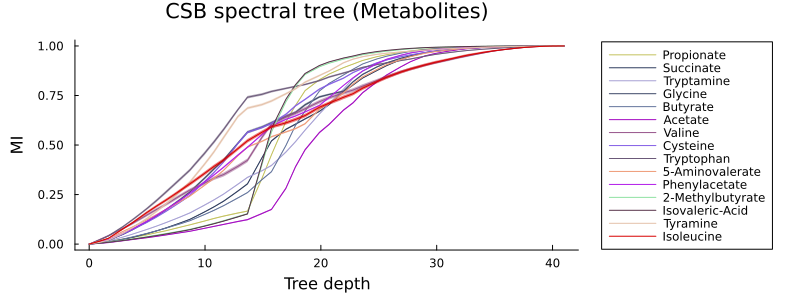

In [62]:
metabolitelevels = permutedims(string.(metabolite_labels))
# metabolitecolors = repeat([:purple], length(taxonomylevels));
metabolitecolors = palette(:acton, length(metabolite_labels)).colors.colors
metabolitecolors = palette(:glasbey_bw_n256, length(metabolite_labels)).colors.colors

minmax = extrema(mapinternalnodes(network_distance, spi_tree_50pct, spi_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS)

plot(title="CSB spectral tree (Metabolites)", ylabel="MI", xlabel="Tree depth",
    legend=:outerright,
    size=(800,300), 
    margin=5Plots.Measures.mm, 
)
for (tlab, tcol) in reverse(collect(zip(metabolitelevels, metabolitecolors)))
    df = filter(:taxaID=> ==(tlab), boot_SPI_pltdf)
    @df df plot!(cuts, :cumulative_boot_mean, ribbon=2 .* :cumulative_boot_std, label=tlab, c=tcol, lw=1)
end
plot!()

In [11]:
spiMI_df_ncbi = CSV.read(joinpath(rdir, "spi_MI_ncbi.csv"), DataFrame)
SPI_pltdf_ncbi = CSV.read(joinpath(rdir, "spi_MI_ncbi_bootstraps.csv"), DataFrame)
boot_SPI_pltdf_ncbi = CSV.read(joinpath(rdir, "spi_MI_ncbi_bootstraps_aggregated.csv"), DataFrame);

spiMI_df = CSV.read(joinpath(rdir, "spi_MI_metabolite.csv"), DataFrame)
SPI_pltdf = CSV.read(joinpath(rdir, "spi_MI_metabolite_bootstraps.csv"), DataFrame)
boot_SPI_pltdf = CSV.read(joinpath(rdir, "spi_MI_metabolite_bootstraps_aggregated.csv"), DataFrame);

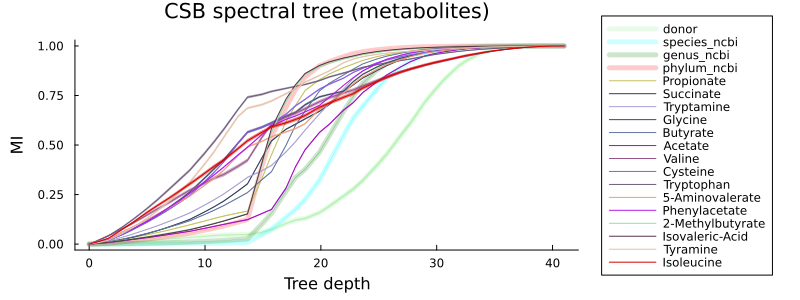

In [12]:
taxonomylevels = permutedims(["phylum_ncbi", "genus_ncbi", "species_ncbi", "donor"])
taxarankcolors = [:red :green :aqua :lightgreen];
minmax = extrema(mapinternalnodes(network_distance, spi_tree_50pct, spi_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS)

plot(title="CSB spectral tree (metabolites)", ylabel="MI", xlabel="Tree depth",
    legend=:outerright,
    size=(800,300), 
    margin=5Plots.Measures.mm,  
)
for (tlab, tcol) in reverse(collect(zip(taxonomylevels, taxarankcolors)))
    df = filter(:taxaID=> ==(tlab), boot_SPI_pltdf_ncbi)
    @df df plot!(cuts, :cumulative_boot_mean, ribbon=2 .* :cumulative_boot_std, label=tlab, c=tcol, lw=5, alpha=.2)
end
# plot!()

metabolitelevels = permutedims(string.(metabolite_labels))
# metabolitecolors = repeat([:purple], length(taxonomylevels));
# metabolitecolors = palette(:acton, length(metabolite_labels)).colors.colors
metabolitecolors = palette(:glasbey_bw_n256, length(metabolite_labels)).colors.colors

minmax = extrema(mapinternalnodes(network_distance, spi_tree_50pct, spi_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS)

for (tlab, tcol) in reverse(collect(zip(metabolitelevels, metabolitecolors)))
    df = filter(:taxaID=> ==(tlab), boot_SPI_pltdf)
    @df df plot!(cuts, :cumulative_boot_mean, ribbon=2 .* :cumulative_boot_std, label=tlab, c=tcol, lw=1)
end
plot!()

 ## Metabolite MI (StrVar)

In [44]:
improved_metabolites = [
    "Isoleucine", "Tyramine", "Isovaleric-Acid", "2-Methylbutyrate", "Phenylacetate",
    "5-Aminovalerate", "Tryptophan", "Cysteine", "Valine", "Acetate", "Butyrate",
    "Glycine", "Tryptamine", "Succinate", "Propionate",
];

In [45]:

metabolite_names = replace.(biobank["metabolites_foldchange"].var_names, "_rel"=>"")
metabolite_mask = indexin(improved_metabolites, metabolite_names)
metabolite_labels = metabolite_names[metabolite_mask];

In [46]:
metmtx = biobank["metabolites_foldchange"].X[:,:][:, metabolite_mask];

In [47]:
keptspecies = string.(keys(sort(filter(x-> last(x) > 19, countmap(biobank.obs.species)), byvalue=true, rev=true)))
filter!(!=("unclassified"), keptspecies)
full_train_mask = in.(biobank.obs.species, Ref(keptspecies));
full_test_mask = .!(full_train_mask);

subsetDij = biobank["UPorder_oggs"].obsp["SDij"][full_train_mask, full_train_mask];
subsettree_hc = hclust(subsetDij, linkage=:average, branchorder=:optimal)
subsettreestring = SPI.nwstr(subsettree_hc, biobank.obs.ID[full_train_mask]; labelinternalnodes=false)
subsettree = readnw(subsettreestring);

In [48]:
# spi_tree_50pct = as_polytomy(n->NewickTree.support(n)<0.5, csbspitree);
rowmeta = DataFrame(metmtx[full_train_mask,:], metabolite_labels)
havelabels = nothing
IDS = csbobs.ID[full_train_mask];

In [80]:
@info "calculate tree cuts for SPI tree..."
@time clusterids, clustersmps = clusters_per_cutlevel(NewickTreeTools.network_distance, subsettree, NCUTS);

@info "calculate test MI for SPI tree..."
@time spiMI_df = pairedMIagainstnumericcolumn(rowmeta, IDS, clusterids, clustersmps; mask=havelabels);

@info "calculate boot MI for SPI tree..."
@time spiMI_bootstrapped = map(1:NBOOT) do i
    df = pairedMIagainstnumericcolumn(rowmeta, IDS, clusterids, clustersmps; bootstrap=true, mask=havelabels)
    df.MI
end |> stack


@info "reformat boot replicates..."
@time begin
spiMI_df[!, :MI_boot_mean] = vec(mean(spiMI_bootstrapped, dims=2))
spiMI_df[!, :MI_boot_std] = vec(std(spiMI_bootstrapped, dims=2));
spiMI__bootstraps_df = DataFrame(spiMI_bootstrapped, [Symbol("MI_boot_$i") for i in 1:size(spiMI_bootstrapped, 2)]);
SPI_pltdf = hcat(spiMI_df, spiMI__bootstraps_df);
boot_SPI_pltdf = SPI_pltdf[!, ["taxaID", ["MI_boot_$i" for i in 1:NBOOT]...]] |>
    df-> groupby(df, :taxaID) |>
    gdf-> DataFrames.combine(gdf,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ms = vec(mean(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_mean,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ss = vec(std(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_std,
    );
end

┌ Info: calculate boot MI for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/18_CSB669_MIcurves.ipynb:1


234.265646 seconds (4.02 M allocations: 147.927 GiB, 4.29% gc time, 0.05% compilation time)


┌ Info: reformat boot replicates...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/18_CSB669_MIcurves.ipynb:8


  0.154053 seconds (136.86 k allocations: 15.221 MiB, 94.95% compilation time)


Row,taxaID,cumulative_boot_mean,cumulative_boot_std
,String,Float64,Float64
1,Isoleucine,0.0,0.0
2,Isoleucine,0.0202299,0.00166142
3,Isoleucine,0.0401149,0.00193792
4,Isoleucine,0.060256,0.00248258
5,Isoleucine,0.0804591,0.00322854
6,Isoleucine,0.113132,0.00368527
7,Isoleucine,0.146012,0.00405604
8,Isoleucine,0.178141,0.00431258
9,Isoleucine,0.210376,0.00437561


In [ ]:
CSV.write(joinpath(rdir, "spi_MI_metabolite_strvar.csv"), spiMI_df)
CSV.write(joinpath(rdir, "spi_MI_metabolite_strvar_bootstraps.csv"), SPI_pltdf)
CSV.write(joinpath(rdir, "spi_MI_metabolite_strvar_bootstraps_aggregated.csv"), boot_SPI_pltdf)

In [68]:
# spi_tree_50pct = as_polytomy(n->NewickTree.support(n)<0.5, csbspitree);
rowmeta = csbobs[full_train_mask, ncbi_cols]
havelabels = vec(mapslices(r->all(r .!= "<unclassified>"), Matrix(rowmeta), dims=2));
IDS = csbobs.ID[full_train_mask];

@info "calculate tree cuts for SPI tree..."
@time clusterids, clustersmps = clusters_per_cutlevel(NewickTreeTools.network_distance, subsettree, NCUTS);

@info "calculate test MI for SPI tree..."
@time spiMI_df_ncbi = pairedMIagainstmetacolumn(rowmeta, IDS, clusterids, clustersmps; mask=havelabels);

@info "calculate boot MI for SPI tree..."
@time spiMI_bootstrapped = map(1:NBOOT) do i
    df = pairedMIagainstmetacolumn(rowmeta, IDS, clusterids, clustersmps; bootstrap=true, mask=havelabels)
    df.MI
end |> stack


@info "reformat boot replicates..."
@time begin
spiMI_df_ncbi[!, :MI_boot_mean] = vec(mean(spiMI_bootstrapped, dims=2))
spiMI_df_ncbi[!, :MI_boot_std] = vec(std(spiMI_bootstrapped, dims=2));
spiMI__bootstraps_df_ncbi = DataFrame(spiMI_bootstrapped, [Symbol("MI_boot_$i") for i in 1:size(spiMI_bootstrapped, 2)]);
SPI_pltdf_ncbi = hcat(spiMI_df_ncbi, spiMI__bootstraps_df_ncbi);
boot_SPI_pltdf_ncbi = SPI_pltdf_ncbi[!, ["taxaID", ["MI_boot_$i" for i in 1:NBOOT]...]] |>
    df-> groupby(df, :taxaID) |>
    gdf-> DataFrames.combine(gdf,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ms = vec(mean(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_mean,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ss = vec(std(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_std,
    );
end

┌ Info: calculate tree cuts for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/18_CSB669_MIcurves.ipynb:6


  1.517429 seconds (4.13 M allocations: 275.851 MiB, 8.01% gc time, 82.47% compilation time)


┌ Info: calculate test MI for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/18_CSB669_MIcurves.ipynb:9


  6.131121 seconds (7.47 M allocations: 1.111 GiB, 6.98% gc time, 76.57% compilation time: <1% of which was recompilation)


┌ Info: calculate boot MI for SPI tree...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/18_CSB669_MIcurves.ipynb:12


 86.606065 seconds (6.64 M allocations: 47.999 GiB, 7.83% gc time, 0.79% compilation time: <1% of which was recompilation)


┌ Info: reformat boot replicates...
└ @ Main /Users/ben/projects/Doran_etal_2022/notebooks/reports/18_CSB669_MIcurves.ipynb:19


  2.696390 seconds (4.79 M allocations: 305.870 MiB, 6.67% gc time, 99.59% compilation time: <1% of which was recompilation)


Row,taxaID,cumulative_boot_mean,cumulative_boot_std
,String,Float64,Float64
1,phylum_ncbi,0.0,0.0
2,phylum_ncbi,0.0876179,0.000436377
3,phylum_ncbi,0.175309,0.00059986
4,phylum_ncbi,0.263061,0.000769346
5,phylum_ncbi,0.350725,0.000948112
6,phylum_ncbi,0.399827,0.00103442
7,phylum_ncbi,0.44899,0.000988176
8,phylum_ncbi,0.498229,0.000993504
9,phylum_ncbi,0.547219,0.00101086


In [69]:
CSV.write(joinpath(rdir, "spi_MI_ncbi_strvar.csv"), spiMI_df_ncbi)
CSV.write(joinpath(rdir, "spi_MI_ncbi_strvar_bootstraps.csv"), SPI_pltdf_ncbi)
CSV.write(joinpath(rdir, "spi_MI_ncbi_strvar_bootstraps_aggregated.csv"), boot_SPI_pltdf_ncbi)

"/Users/ben/projects/Doran_etal_2022/_research/CSB669_MIcurves/spi_MI_ncbi_strvar_bootstraps_aggregated.csv"

In [70]:
spiMI_df_ncbi = CSV.read(joinpath(rdir, "spi_MI_ncbi_strvar.csv"), DataFrame);
SPI_pltdf_ncbi = CSV.read(joinpath(rdir, "spi_MI_ncbi_strvar_bootstraps.csv"), DataFrame);
boot_SPI_pltdf_ncbi = CSV.read(joinpath(rdir, "spi_MI_ncbi_strvar_bootstraps_aggregated.csv"), DataFrame);

spiMI_df = CSV.read(joinpath(rdir, "spi_MI_metabolite_strvar.csv"), DataFrame)
SPI_pltdf = CSV.read(joinpath(rdir, "spi_MI_metabolite_strvar_bootstraps.csv"), DataFrame)
boot_SPI_pltdf = CSV.read(joinpath(rdir, "spi_MI_metabolite_strvar_bootstraps_aggregated.csv"), DataFrame);

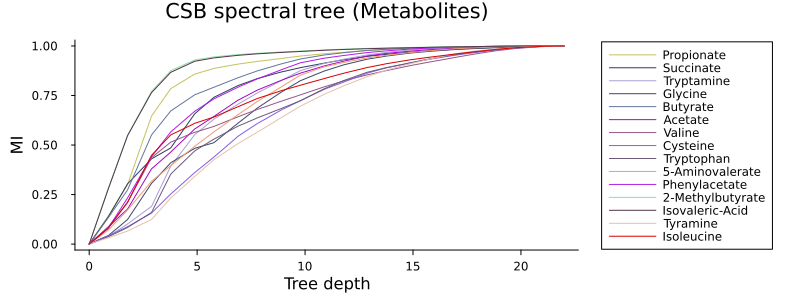

attempt to save state beyond implementation limit


In [72]:
metabolitelevels = permutedims(string.(metabolite_labels))
# metabolitecolors = repeat([:purple], length(taxonomylevels));
# metabolitecolors = palette(:acton, length(metabolite_labels)).colors.colors
metabolitecolors = palette(:glasbey_bw_n256, length(metabolite_labels)).colors.colors

minmax = extrema(mapinternalnodes(network_distance, subsettree, subsettree))
cuts = range(0, minmax[2], length=NCUTS)

plot(title="CSB spectral tree (Metabolites)", ylabel="MI", xlabel="Tree depth",
    legend=:outerright,
    size=(800,300), 
    margin=5Plots.Measures.mm, 
)
for (tlab, tcol) in reverse(collect(zip(metabolitelevels, metabolitecolors)))
    df = filter(:taxaID=> ==(tlab), boot_SPI_pltdf)
    @df df plot!(cuts, :cumulative_boot_mean, label=tlab, c=tcol, lw=1)
end
plot!()

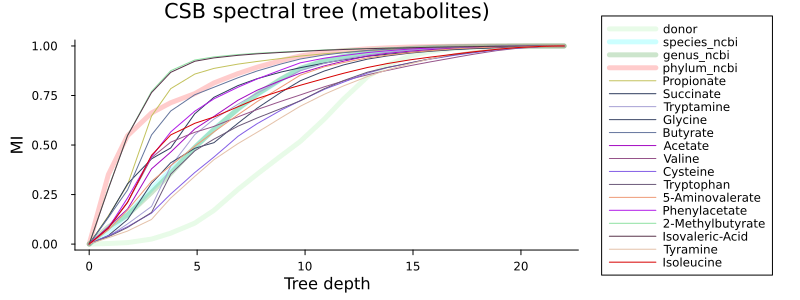

In [74]:
taxonomylevels = permutedims(["phylum_ncbi", "genus_ncbi", "species_ncbi", "donor"])
taxarankcolors = [:red :green :aqua :lightgreen];
minmax = extrema(mapinternalnodes(network_distance, subsettree, subsettree))
cuts = range(0, minmax[2], length=NCUTS)

plot(title="CSB spectral tree (metabolites)", ylabel="MI", xlabel="Tree depth",
    legend=:outerright,
    size=(800,300), 
    margin=5Plots.Measures.mm,  
)
for (tlab, tcol) in reverse(collect(zip(taxonomylevels, taxarankcolors)))
    df = filter(:taxaID => ==(tlab), boot_SPI_pltdf_ncbi)
    @df df plot!(cuts, :cumulative_boot_mean, label=tlab, c=tcol, lw=5, alpha=.2)
end
# plot!()

metabolitelevels = permutedims(string.(metabolite_labels))
metabolitecolors = palette(:glasbey_bw_n256, length(metabolite_labels)).colors.colors

minmax = extrema(mapinternalnodes(network_distance, subsettree, subsettree))
cuts = range(0, minmax[2], length=NCUTS)

for (tlab, tcol) in reverse(collect(zip(metabolitelevels, metabolitecolors)))
    df = filter(:taxaID=> ==(tlab), boot_SPI_pltdf)
    @df df plot!(cuts, :cumulative_boot_mean, label=tlab, c=tcol, lw=1)
end
plot!()

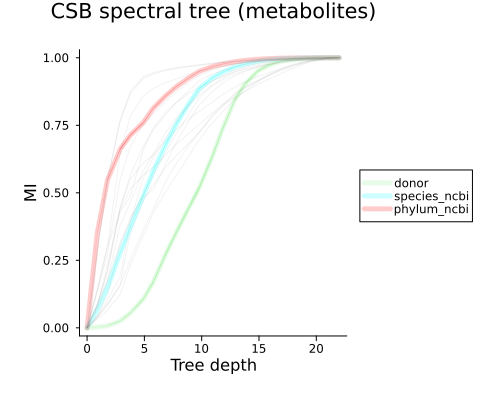

In [75]:
taxonomylevels = permutedims(["phylum_ncbi", "species_ncbi", "donor"])
taxarankcolors = [:red :aqua :lightgreen];
minmax = extrema(mapinternalnodes(network_distance, subsettree, subsettree))
cuts = range(0, minmax[2], length=NCUTS)

plot(title="CSB spectral tree (metabolites)", ylabel="MI", xlabel="Tree depth",
    legend=:outerright,
    size=(500,400), 
    margin=5Plots.Measures.mm,  
)
for (tlab, tcol) in reverse(collect(zip(taxonomylevels, taxarankcolors)))
    df = filter(:taxaID=> ==(tlab), boot_SPI_pltdf_ncbi)
    @df df plot!(cuts, :cumulative_boot_mean, ribbon=2 .* :cumulative_boot_std, label=tlab, c=tcol, lw=5, alpha=.2)
end
# plot!()

metabolitelevels = permutedims(string.(metabolite_labels))
# metabolitecolors = repeat([:purple], length(taxonomylevels));
# metabolitecolors = palette(:acton, length(metabolite_labels)).colors.colors
metabolitecolors = palette(:glasbey_bw_n256, length(metabolite_labels)).colors.colors

minmax = extrema(mapinternalnodes(network_distance, subsettree, subsettree))
cuts = range(0, minmax[2], length=NCUTS)

for (tlab, tcol) in reverse(collect(zip(metabolitelevels, metabolitecolors)))
    df = filter(:taxaID=> ==(tlab), boot_SPI_pltdf)
    @df df plot!(cuts, :cumulative_boot_mean, c=:grey, alpha=.1, lw=1)
end
plot!()

In [76]:
metabolite_groupings = Dict(
    "Isoleucine" => "g3",
    "Tyramine" => "g4",
    "Isovaleric-Acid" => "g1",
    "2-Methylbutyrate" => "g1",
    "Phenylacetate" => "g3",
    "5-Aminovalerate" => "g3",
    "Tryptophan" => "g3",
    "Cysteine" => "g3",
    "Valine" => "g3",
    "Acetate" => "g2",
    "Butyrate" => "g2",
    "Glycine" => "g3",
    "Tryptamine" => "g3",
    "Succinate" => "g1",
    "Propionate" => "g1",
)

Dict{String, String} with 15 entries:
  "Tyramine"         => "g4"
  "Propionate"       => "g1"
  "Tryptophan"       => "g3"
  "Phenylacetate"    => "g3"
  "Cysteine"         => "g3"
  "Valine"           => "g3"
  "Acetate"          => "g2"
  "Glycine"          => "g3"
  "Isovaleric-Acid"  => "g1"
  "Tryptamine"       => "g3"
  "Succinate"        => "g1"
  "2-Methylbutyrate" => "g1"
  "Butyrate"         => "g2"
  "Isoleucine"       => "g3"
  "5-Aminovalerate"  => "g3"

In [77]:
metabolite_individual_pltdf = SPI_pltdf |>
    df -> groupby(df, :taxaID) |>
    df -> transform(df, 
        eachindex => :cutindex,
        :taxaID => ByRow(x-> metabolite_groupings[x]) => :grouping,
    ) |>
    df -> stack(df, 5:54) |>
    df -> groupby(df, [:taxaID, :variable]) |>
    df -> transform(df, 
        eachindex => :cutindex,
        :value => scaledcumsum => :MI_boot_cumsum) |>
    df -> groupby(df, [:taxaID, :cutindex]) |>
    df -> combine(df,
        :grouping,
        :cutindex,
        :MI_boot_cumsum => mean,
        :MI_boot_cumsum => std,
    );

In [78]:
metabolite_grouped_pltdf = metabolite_individual_pltdf |>
    df -> groupby(df, [:grouping, :cutindex]) |>
    df -> combine(df,
        :MI_boot_cumsum_mean => mean => :grp_MI_curve_mean,
        :MI_boot_cumsum_mean => std => :grp_MI_curve_std,
        :MI_boot_cumsum_mean => minimum => :grp_MI_curve_minimum,
        :MI_boot_cumsum_mean => maximum => :grp_MI_curve_maximum,
);

In [79]:
metabolite_grouping_pltdf = SPI_pltdf |> 
    df -> groupby(df, :taxaID) |>
    df -> transform(df, 
        eachindex => :cutindex,
        :taxaID => ByRow(x-> metabolite_groupings[x]) => :grouping,
    ) |>
    df -> stack(df, 5:54) |>
    df -> groupby(df, [:grouping, :variable]) |>
    df -> transform(df, 
        :value => scaledcumsum => :MI_boot_cumsum) |>
    df -> groupby(df, [:grouping, :cutindex]) |>
    df -> combine(df, 
        :MI_boot_cumsum => mean,
        :MI_boot_cumsum => std,
    );

In [81]:
callout_metabolites = [
    "Isovaleric-Acid",
    "2-Methylbutyrate",
    "Acetate",
    "Butyrate",
    "Glycine",
    "Tyramine",
]

6-element Vector{String}:
 "Isovaleric-Acid"
 "2-Methylbutyrate"
 "Acetate"
 "Butyrate"
 "Glycine"
 "Tyramine"

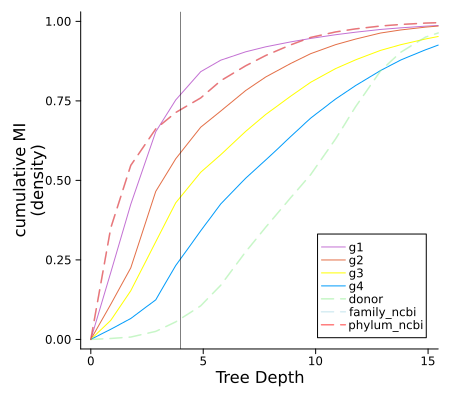

In [87]:
plot(
    ylabel="cumulative MI\n(density)",
    xlabel="Tree Depth",
    size=(450,400),
    xlims=(0,15),
    widen=true,
    legend=:bottomright,
)
@df metabolite_grouped_pltdf plot!(
    repeat(cuts, 4), :grp_MI_curve_mean,
    # ribbon=:grp_MI_curve_std,
    group=:grouping,
    lw=1,
    # label="",
    c=[4 2 :yellow 1]
)

taxonomylevels = permutedims(["phylum_ncbi", "family_ncbi", "donor"])
taxarankcolors = [:red :lightblue :lightgreen];
minmax = extrema(mapinternalnodes(network_distance, subsettree, subsettree))
cuts = range(0, minmax[2], length=NCUTS)

for (tlab, tcol) in reverse(collect(zip(taxonomylevels, taxarankcolors)))
    df = filter(:taxaID=> ==(tlab), boot_SPI_pltdf_ncbi)
    @df df plot!(cuts, :cumulative_boot_mean, label=tlab, c=tcol, lw=1.5, linestyle=:dash, alpha=.5)
end
vline!([4], c=:black, label="",lw=0.5)

In [86]:
savefig(joinpath(pdir, "Metabolite_MI_curves_strvartree_withcalloutmetabolites.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/CSB669_MIcurves/Metabolite_MI_curves_strvartree_withcalloutmetabolites.pdf"

In [35]:
taxonomylevels = permutedims(["phylum_ncbi", "species_ncbi", "donor"])
taxarankcolors = [:red :aqua :lightgreen];
minmax = extrema(mapinternalnodes(network_distance, subsettree, subsettree))
cuts = range(0, minmax[2], length=NCUTS)

plot(
    ylabel="cumulative MI\n(density)",
    xlabel="Tree Depth",
    size=(450,400),
    xlims=(0,15),
    widen=true,
) 
for (tlab, tcol) in reverse(collect(zip(taxonomylevels, taxarankcolors)))
    df = filter(:taxaID=> ==(tlab), boot_SPI_pltdf_ncbi)
    @df df plot!(cuts, :cumulative_boot_mean, label=tlab, c=tcol, lw=5, alpha=.2)
end
plot!()

attempt to save state beyond implementation limit
attempt to save state beyond implementation limit


In [237]:
savefig(joinpath(pdir, "taxonomy_MI_curves_strvartree.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/CSB669_MIcurves/taxonomy_MI_curves_strvartree.pdf"

In [176]:
repeat(cuts, 4)

400-element Vector{Float64}:
  0.0
  0.2222222222222222
  0.4444444444444444
  0.6666666666666666
  0.8888888888888888
  1.1111111111111112
  1.3333333333333333
  1.5555555555555556
  1.7777777777777777
  2.0
  ⋮
 20.22222222222222
 20.444444444444443
 20.666666666666668
 20.88888888888889
 21.11111111111111
 21.333333333333332
 21.555555555555557
 21.77777777777778
 22.0

Row,g3,g4,g1,g2
,Float64?,Float64?,Float64?,Float64?
1,0.0,0.0,0.0,0.0
2,0.00929122,0.00801381,0.0343594,0.0216759
3,0.0186347,0.0161522,0.068958,0.0434024
4,0.0278269,0.0240563,0.103577,0.0650662
5,0.0370118,0.0319501,0.138063,0.0868798
6,0.0486932,0.0402628,0.179533,0.109434
7,0.0604224,0.0489159,0.220939,0.132009
8,0.0721556,0.0574167,0.260113,0.154352
9,0.0840411,0.0657706,0.299343,0.176802


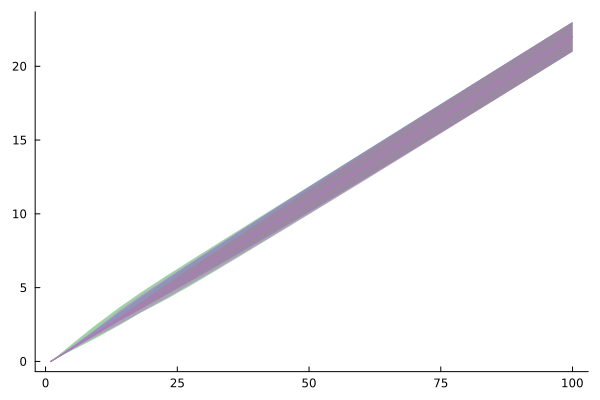

In [183]:
lowerbounds = Matrix(unstack(metabolite_grouped_pltdf, :cutindex, :grouping, :grp_MI_curve_minimum)[:,2:5])
upperbounds = Matrix(unstack(metabolite_grouped_pltdf, :cutindex, :grouping, :grp_MI_curve_maximum)[:,2:5]);
plot([cuts cuts cuts cuts]; ribbon=(lowerbounds, upperbounds),
)

In [172]:
metabolite_grouped_pltdf

Row,grouping,cutindex,grp_MI_curve_mean,grp_MI_curve_std,grp_MI_curve_minimum,grp_MI_curve_maximum
,String,Int64,Float64,Float64,Float64,Float64
1,g3,1,0.0,0.0,0.0,0.0
2,g3,2,0.0150049,0.00500574,0.00929122,0.0212673
3,g3,3,0.0300884,0.0100723,0.0186347,0.0432205
4,g3,4,0.045011,0.0152052,0.0278269,0.0649103
5,g3,5,0.0599871,0.0204157,0.0370118,0.0868476
6,g3,6,0.0832777,0.0293855,0.0486932,0.119231
7,g3,7,0.106551,0.0386607,0.0604224,0.157194
8,g3,8,0.129782,0.0477933,0.0721556,0.195181
9,g3,9,0.153085,0.0570809,0.0840411,0.233025
